In [1]:
import sys
sys.path.append('/home/yihan/cvg/implicit_radial_sfm')
from calib_reader import *
# from ``scripts/python/database.py`` import everything
from scripts.python.database import *
import os
import pyimplicitdist
import matplotlib as plt





In [7]:
base_path = '/home/yihan/cvg/implicit_radial_sfm/experimental_scripts/babelcalib/data/'
output_db_base = '/home/yihan/cvg/babelcalib/data/databases'
output_calib_base = '/home/yihan/cvg/babelcalib/data/calibrations'

# dataset_train, dataset_test, calib_train, calib_test, dataset, calib, poses_train, poses_test, poses=load_data('/home/yihan/cvg/implicit_radial_sfm/experimental_scripts/babelcalib/data/OCamCalib_Fisheye190deg.mat')
# load data and split to train and test
dataset_train, dataset_test, corrs_train, corrs_test, poses_train, poses_test, calib_train, calib_test, fov = load_data('/home/yihan/cvg/implicit_radial_sfm/experimental_scripts/babelcalib/data/UZH_DAVIS_indoor_45.mat')


(3, 4, 50)
(3, 4, 35)


In [ ]:
spline_path = '/home/yihan/cvg/implicit_radial_sfm/experimental_scripts/babelcalib/spline/UZH_DAVIS_indoor_45_spline.txt'
out = {}
out['pp'] = np.array(200, 300)


In [30]:
def rotation_to_quaternion(R):
    q = np.zeros(4)
    q[0] = np.sqrt(1 + R[0, 0] + R[1, 1] + R[2, 2]) / 2
    q[1] = (R[2, 1] - R[1, 2]) / (4 * q[0])
    q[2] = (R[0, 2] - R[2, 0]) / (4 * q[0])
    q[3] = (R[1, 0] - R[0, 1]) / (4 * q[0])
    return q

In [53]:
# Get intrinsic calibration from implicit distortion model
# get 2d points from corrs_train
def get_intrinsics(dataset_train,corrs_train, poses_train, output_path):
   
    points2d = []
    points3d = []
    for corr in corrs_train:
        points2d.append(corr[0])
        points3d.append(corr[1])
    points2d = np.array(points2d)
    points3d = np.array(points3d)
    cm_opt = pyimplicitdist.CostMatrixOptions()
    image_size = dataset_train['imgsize']
    pp = np.array([image_size[1]/2, image_size[0]/2])
    
    
    poses = []
    for pose in poses_train:
        # transform pose.R to quaternion
        q  = rotation_to_quaternion(pose.R)
        p = pyimplicitdist.CameraPose(q, pose.t)
        poses.append(p)
    # get intrinsic calibration
    out = pyimplicitdist.joint_pose_refinement_1D_radial(points2d, points3d, poses, pp, pyimplicitdist.PoseRefinement1DRadialOptions())
    
    pp = out['pp']
    cost_matrix =  pyimplicitdist.build_cost_matrix_multi(points2d, cm_opt, pp)
    if not os.path.exists(output_path):
        
        intrinsics = pyimplicitdist.calibrate_multi(points2d, points3d, cost_matrix,  pp, poses)
        np.savetxt(output_path, intrinsics.theta_r)
        print('Intrinsic calibration saved to {}'.format(output_path))
    
    return out


In [5]:
theta = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
radii = [1, 4, 9, 16, 25, 36, 49, 64, 81, 100]
import scipy.interpolate
spline = scipy.interpolate.CubicSpline(theta, radii, bc_type='natural')
theta_new = np.linspace(1, 10, 1000)
for t in theta_new:
    # keep 4 decimal places and print both theta and radii
    print("{:.5f} {:.5f}".format(t, spline(t)))

1.00000 1.00000
1.00901 1.02322
1.01802 1.04644
1.02703 1.06967
1.03604 1.09290
1.04505 1.11614
1.05405 1.13938
1.06306 1.16264
1.07207 1.18591
1.08108 1.20920
1.09009 1.23250
1.09910 1.25583
1.10811 1.27917
1.11712 1.30253
1.12613 1.32592
1.13514 1.34933
1.14414 1.37278
1.15315 1.39625
1.16216 1.41975
1.17117 1.44329
1.18018 1.46686
1.18919 1.49047
1.19820 1.51412
1.20721 1.53781
1.21622 1.56154
1.22523 1.58531
1.23423 1.60914
1.24324 1.63301
1.25225 1.65693
1.26126 1.68090
1.27027 1.70493
1.27928 1.72901
1.28829 1.75315
1.29730 1.77735
1.30631 1.80161
1.31532 1.82593
1.32432 1.85032
1.33333 1.87477
1.34234 1.89930
1.35135 1.92389
1.36036 1.94856
1.36937 1.97330
1.37838 1.99811
1.38739 2.02301
1.39640 2.04798
1.40541 2.07304
1.41441 2.09817
1.42342 2.12340
1.43243 2.14871
1.44144 2.17411
1.45045 2.19960
1.45946 2.22519
1.46847 2.25086
1.47748 2.27664
1.48649 2.30251
1.49550 2.32848
1.50450 2.35456
1.51351 2.38074
1.52252 2.40702
1.53153 2.43342
1.54054 2.45992
1.54955 2.48653
1.55856 

In [59]:
# # plot the intrisics.theta_r
# import matplotlib.pyplot as plt
# write intrinsics.theta_r to a file
def spline_fit(theta_r_path):
    theta = []
    r = []
    # read theta_r from file
    theta_r = np.loadtxt(theta_r_path)
    for i in range(0, len(theta_r)):
        theta.append(theta_r[i][0])
        r.append(theta_r[i][1]) 
    # fit a cubic spline to theta_r
    import scipy.interpolate
    thetas = np.array(theta)
    rs = np.array(r)
    theta_r_spline = scipy.interpolate.CubicSpline(thetas, rs, bc_type='natural')
    return thetas, theta_r_spline


In [60]:
# calculate the mean reprojection error for test set
def calculate_mean_reproj_error(corrs_test, poses_test,theta_r_spline, thetas, out):
    mean_reprojection_error = 0
    point_count = 0
    total_points = 0
    for i in range(0, len(corrs_test)):
        corr = corrs_test[i]
        points2d = corr[0]
        points3d = corr[1]
        # get the camera pose
        pose = poses_test[i]
        # for each point, calculate the reprojection error
        for j in range(0, len(points2d)):
            point2d = points2d[j]
            point3d = points3d[j]
            # project 3d point into camera coordinate using pose.R and pose.t
            point3d_cam = pose.R @ point3d + pose.t
            # get the viewing angle theta from the point3d_cam
            rho = np.sqrt(point3d_cam[0]**2 + point3d_cam[1]**2)
            theta = np.arctan2(rho, point3d_cam[2])
            if theta >= thetas[0] and theta <= thetas[-1]:
            # get r from theta_r_spline
                r = theta_r_spline(theta)
                f = r / np.tan(theta)
                # get the projection of 3d point
                u_proj = f * point3d_cam[0] / point3d_cam[2] + out['pp'] [0]
                v_proj = f * point3d_cam[1] / point3d_cam[2] + out['pp'] [1]
                # u_proj = f * point3d_cam[0] / point3d_cam[2] + pp[0]
                # v_proj = f * point3d_cam[1] / point3d_cam[2] + pp[1]
                # calculate the reprojection error
                error = np.sqrt((u_proj - point2d[0])**2 + (v_proj - point2d[1])**2)
                # print(error)
                mean_reprojection_error += error
                point_count += 1
            total_points += 1
    mean_reprojection_error /= point_count
    calibrated_points = point_count / total_points
    return mean_reprojection_error, calibrated_points


         

    

In [63]:
results = {'OV_corner': [], 'OV_cube': [], 'OV_single_plane': [], 'Kalibr': [], 'OCamCalib': [], 'UZH_DAVIS': [], 'UZH_Snapdragon': []}
base_path = '/home/yihan/cvg/implicit_radial_sfm/experimental_scripts/babelcalib/data/'
output_base = '/home/yihan/cvg/implicit_radial_sfm/experimental_scripts/babelcalib/eval/'
spline_base = '/home/yihan/cvg/implicit_radial_sfm/experimental_scripts/babelcalib/spline/'
for query_file in os.listdir(base_path):
    if query_file.endswith('.mat'):
        # print(query_file)
        dataset_train, dataset_test, corrs_train, corrs_test, poses_train, poses_test, calib_train, calib_test, fov = load_data(base_path + query_file)
        output_path = output_base + query_file.split('.')[0] + '_theta_r.txt'
    
        out = get_intrinsics(dataset_train, corrs_train, poses_train, output_path)
        spline_path = spline_base + query_file.split('.')[0] + '_spline.txt'
        if  os.path.exists(spline_path):
            thetas, theta_r_spline = spline_fit(spline_path)
            mean_reprojection_error, calibrated_points = calculate_mean_reproj_error(corrs_test, poses_test,theta_r_spline, thetas,out)
            if query_file.startswith('OV_corner'):
                results['OV_corner'].append([mean_reprojection_error, calibrated_points])
            elif query_file.startswith('OV_cube'):
                results['OV_cube'].append([mean_reprojection_error, calibrated_points])
            elif query_file.startswith('OV_single_plane'):
                results['OV_single_plane'].append([mean_reprojection_error, calibrated_points])
            elif query_file.startswith('Kalibr'):
                results['Kalibr'].append([mean_reprojection_error, calibrated_points])
            elif query_file.startswith('OCamCalib'):
                results['OCamCalib'].append([mean_reprojection_error, calibrated_points])
            elif query_file.startswith('UZH_DAVIS'):
                results['UZH_DAVIS'].append([mean_reprojection_error, calibrated_points])
            elif query_file.startswith('UZH_Snapdragon'):
                results['UZH_Snapdragon'].append([mean_reprojection_error, calibrated_points])
# calculate the mean reprojection error and calibrated points for each dataset
for key in results:
    mean_reprojection_error = 0
    calibrated_points = 0
    for result in results[key]:
        mean_reprojection_error += result[0]
        calibrated_points += result[1]
    mean_reprojection_error /= len(results[key])
    calibrated_points /= len(results[key])
    # keep 4 decimal places
    mean_reprojection_error = round(mean_reprojection_error, 3)
    calibrated_points = round(calibrated_points, 3)
    print(key, mean_reprojection_error, calibrated_points)


(3, 4, 50)
(3, 4, 35)
(3, 4, 50)
(3, 4, 35)


/tmp/ipykernel_2728/2487839132.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  points2d = np.array(points2d)
/tmp/ipykernel_2728/2487839132.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  points3d = np.array(points3d)


(3, 4, 50)
(3, 4, 35)
(3, 4, 37)
(3, 4, 25)
(3, 4, 50)
(3, 4, 35)
(3, 4, 45)
(3, 4, 31)
(3, 4, 50)
(3, 4, 35)
(3, 4, 50)
(3, 4, 35)
(3, 4, 50)
(3, 4, 35)
(3, 4, 50)
(3, 4, 35)
(3, 4, 50)
(3, 4, 35)
(3, 4, 50)
(3, 4, 35)
(3, 4, 28)
(3, 4, 19)
(3, 4, 50)
(3, 4, 35)
(3, 4, 50)
(3, 4, 35)
(3, 4, 13)
(3, 4, 9)
(3, 4, 12)
(3, 4, 8)
(3, 4, 50)
(3, 4, 35)
(3, 4, 50)
(3, 4, 35)
(3, 4, 50)
(3, 4, 35)
(3, 4, 50)
(3, 4, 35)
(3, 4, 50)
(3, 4, 35)
(3, 4, 11)
(3, 4, 7)
(3, 4, 8)
(3, 4, 5)
(3, 4, 37)
(3, 4, 25)
(3, 4, 50)
(3, 4, 35)
(3, 4, 50)
(3, 4, 35)
(3, 4, 16)
(3, 4, 11)
(3, 4, 50)
(3, 4, 35)
(3, 4, 10)
(3, 4, 7)
(3, 4, 50)
(3, 4, 35)
(3, 4, 17)
(3, 4, 11)
(3, 4, 50)
(3, 4, 35)
(3, 4, 15)
(3, 4, 10)
(3, 4, 50)
(3, 4, 35)
(3, 4, 15)
(3, 4, 10)
(3, 4, 50)
(3, 4, 35)
(3, 4, 50)
(3, 4, 35)
(3, 4, 35)
(3, 4, 24)
(3, 4, 14)
(3, 4, 9)
OV_corner 16.532 0.994
OV_cube 0.631 0.865
OV_single_plane 1.418 0.644
Kalibr 1.065 0.613
OCamCalib 4.829 0.127
UZH_DAVIS 0.676 0.317
UZH_Snapdragon 0.59 0.346


In [58]:
results

{'OV_corner': [[26.205757034126194, 0.997576084029087],
  [16.429536035904647, 0.9979360165118679],
  [17.39432893247486, 0.9909812895409881],
  [9.273076991631246, 0.9897459799580517],
  [14.919211603026087, 0.9962485932224584],
  [20.03010470185183, 0.9987689277360581],
  [16.02741589235048, 0.9832041343669251],
  [11.718995038155162, 0.9976874793524942]],
 'OV_cube': [[0.4281049454418688, 0.8152254249815225],
  [1.2709021472485862, 0.9666019417475729],
  [0.5403169062662689, 0.871787118234049],
  [0.40929235088913785, 0.8078155028827675]],
 'OV_single_plane': [[0.7711142891935803, 0.9324808184143223],
  [2.4157410182964876, 0.18601398601398603],
  [1.3242584227275105, 0.8127208480565371]],
 'Kalibr': [[1.045476044460812, 0.26995565410199557],
  [1.324179556496501, 0.20147874306839186],
  [0.4395314777529684, 0.39554881133029846],
  [1.6961412862931746, 0.7232490272373541],
  [1.5089059283868969, 0.7570707070707071],
  [0.3937343311567265, 0.7884146341463415],
  [0.3227813617761402, 

In [43]:
def add_correspondences_to_database(database_path, corrs, poses, calib):
    db = COLMAPDatabase.connect(database_path)
    db.create_tables()

    # Define camera parameters and add camera to database
    camera_model = 12 # OPENCV_FISHEYE or appropriate model ID
    width, height = calib.get('width', 1280), calib.get('height', 800)
    # params = np.array(calib['params'])
    params = np.array([width, height, 350.000000, 700.000000, 1050.000000, 1400.000000, 1750.000000, 2100.000000, 2450.000000, 2800.000000, 3150.000000, 3500.000000, 3400.000000, 3380.000000, 3360.000000, 3340.000000, 3330.000000, 3310.000000, 3290.000000, 3280.000000, 3280.000000, 3300.000000])
    camera_id = db.add_camera(camera_model, width, height, params)

    # Add images and keypoints to database
    image_ids = []
    for i, (p2d, _, _, _) in enumerate(corrs):
        image_name = f"image_{i}.png"  # Replace with actual image names if available
        image_id = db.add_image(image_name, camera_id)
        image_ids.append(image_id)
        db.add_keypoints(image_id, np.array(p2d, dtype=np.float32))

    # Find matches and add two-view geometries with the correct pair_id
    for i in range(len(corrs)):
        for j in range(i + 1, len(corrs)):
            matches = []

            # Identify common 3D points between images i and j
            _, p3d_i, full_idx_i, _ = corrs[i]
            _, p3d_j, full_idx_j, _ = corrs[j]
            common_indices = {idx: (np.where(full_idx_i == idx)[0][0],
                                    np.where(full_idx_j == idx)[0][0])
                              for idx in set(full_idx_i) & set(full_idx_j)}

            for idx, (pt_i, pt_j) in common_indices.items():
                matches.append([pt_i, pt_j])

            if matches:
                # Convert matches list to numpy array
                matches_array = np.array(matches, dtype=np.uint32)

                # Calculate pair_id for the image pair
                if image_ids[i] < image_ids[j]:
                    # pair_id = image_ids_to_pair_id(image_ids[i], image_ids[j])
                # pair_id = image_ids_to_pair_id(image_ids[i], image_ids[j])

                # Add matches to the database using the computed pair_id
                    db.add_matches(image_ids[i], image_ids[j], matches_array)
                    db.add_two_view_geometry(image_ids[i],image_ids[j], matches_array)
                    print(f"Added {len(matches)} matches between image {i} and image {j}")
        

    db.commit()
    db.close()

In [6]:
# list all the files in the directory ending with .mat
for query_file in os.listdir(base_path):
    if query_file.endswith('.mat'): 

        print('Processing', query_file)
        corrs, poses, calib, fov = load_data(base_path + query_file)
        # check the name of the file
        calib_dict = calib_to_dict(calib)
        if 'OV_' in query_file:
            calib_dict['width'] = 1280
            calib_dict['height'] = 800
        elif 'Kalibr_BF2M2020S23' in query_file:
            calib_dict['width'] = 1280
            calib_dict['height'] = 1024
        elif 'Kalibr_BM2820' in query_file:
            calib_dict['width'] = 1280
            calib_dict['height'] = 1024
        elif 'Kalibr_BF5M13720' in query_file:
            calib_dict['width'] = 1280
            calib_dict['height'] = 1024
        elif 'Kalibr_BM4018S118' in query_file: 
            calib_dict['width'] = 1280
            calib_dict['height'] = 1024
        elif 'Kalibr_ENTANIYA' in query_file:
            calib_dict['width'] = 1680
            calib_dict['height'] = 1680
        elif 'Kalibr_EUROC' in query_file:
            calib_dict['width'] = 752
            calib_dict['height'] = 480
        elif 'Kalibr_GOPRO' in query_file:
            calib_dict['width'] = 1680
            calib_dict['height'] = 1680
        elif 'Kalibr_TUMVI' in query_file:
            calib_dict['width'] = 512
            calib_dict['height'] = 512
        elif 'UZH_DAVIS' in query_file:
            calib_dict['width'] = 346
            calib_dict['height'] = 260
        elif 'OCamCalib_Fisheye1' in query_file:
            calib_dict['width'] = 1032
            calib_dict['height'] = 778
        elif 'OCamCalib_Fisheye2' in query_file:
            calib_dict['width'] = 748
            calib_dict['height'] = 480
        elif 'OCamCalib_Fisheye190deg' in query_file:
            calib_dict['width'] = 752
            calib_dict['height'] = 480
        elif 'OCamCalib_GOPR' in query_file:
            calib_dict['width'] = 3840
            calib_dict['height'] = 2880
        elif 'OCamCalib_KaidanOmni' in query_file:
            calib_dict['width'] = 640
            calib_dict['height'] = 480
        elif 'OCamCalib_Ladybug' in query_file:
            calib_dict['width'] = 1024
            calib_dict['height'] = 768
        elif 'OCamCalib_MiniOmni' in query_file:
            calib_dict['width'] = 752
            calib_dict['height'] = 480
        elif 'OCamCalib_Omni' in query_file:
            calib_dict['width'] = 1280
            calib_dict['height'] = 960
        elif 'OCamCalib_VMRImage' in query_file:
            calib_dict['width'] = 1024
            calib_dict['height'] = 768
        else:
            print('Unknown image size for', query_file) 
            continue

        # create the database
        output_db_dir = os.path.join(output_db_base, query_file.split('.')[0]) + '.db'
        print(output_db_dir)
        # add_correspondences_to_database(output_db_dir, corrs, poses, calib_dict)
        # save the calibration to the output directory
        output_calib_dir = os.path.join(output_calib_base, query_file.split('.')[0]) + '.txt'
        # write calib_dict['params'] to the output directory
        with open(output_calib_dir, 'w') as f:
            for item in calib_dict['params']:
                f.write("%s\n" % item)
       

Processing UZH_DAVIS_outdoor_forward.mat
(3, 4, 50)
(3, 4, 35)


ValueError: too many values to unpack (expected 4)

In [14]:
calib_dict

{'model': 'OPENCV_FISHEYE',
 'width': -1,
 'height': -1,
 'params': [350.21443464229685,
  350.25975308542985,
  632.548773768803,
  401.7979702302467,
  -0.05305133748923794,
  -0.00733511945899501,
  0.0014036580858569,
  -0.0003926476515198011]}

In [16]:
calib_dict['width'] = 1280
calib_dict['height'] = 800

In [ ]:
# OV: 1280, 800
# Kalibr_BF2M2020S23: 1280, 1024
# Kalibr_BM2820: 1280, 1024
# Kalibr_BF5M13720: 1280, 1024
# Kalibr_BM4018S118: 1280, 1024
# Kalibr_ENTANIYA: 1680, 1680
# Kalibr_EUROC: 752, 480
# Kalibr_GoPro: 1680, 1680
# Kalibr_TUMVI: 512, 512
# UZH_DAVIS: 346, 260
# UZH_Snapdragon:  640, 480
# OCamCalib_Fisheye_1: 1032, 778
# OCamCalib_Fisheye_2: 748, 480
# OCamCalib_Fisheye190deg: 752, 480
# OCamCalib_GOPR: 3840, 2880
# OcamCaliB_KaidanOmni: 640, 480
# OCamCalib_Ladybug: 1024, 768
# OCamCalib_MiniOmni: 752, 480
# OcamCalib_Omni: 1280, 960
# OCamCalib_VMRImage: 1024, 768







(768, 1024)

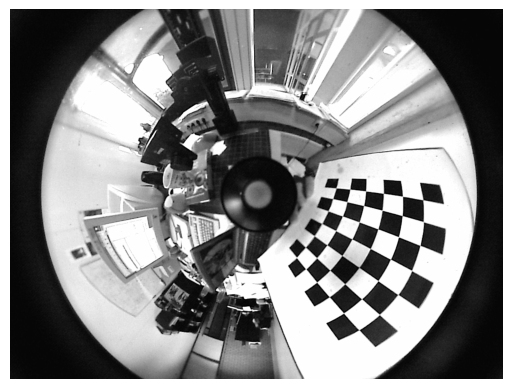

In [25]:
# read a pgm image and determine the image size
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image_path = '/home/yihan/Downloads/OCamCalib/OCamCalib/VMRImage/train/VMRImage0.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
# turn off axis
plt.axis('off')
# size of the image
image.shape


In [8]:
len(corrs)

50

In [18]:
add_correspondences_to_database('database_cube.db', corrs, poses, calib_dict)

Added 154 matches between image 0 and image 1
Added 176 matches between image 0 and image 2
Added 239 matches between image 0 and image 3
Added 78 matches between image 0 and image 4
Added 192 matches between image 0 and image 5
Added 147 matches between image 0 and image 6
Added 128 matches between image 0 and image 7
Added 153 matches between image 0 and image 8
Added 113 matches between image 0 and image 9
Added 176 matches between image 0 and image 10
Added 57 matches between image 0 and image 11
Added 271 matches between image 0 and image 12
Added 248 matches between image 0 and image 13
Added 184 matches between image 0 and image 14
Added 138 matches between image 0 and image 15
Added 84 matches between image 0 and image 16
Added 81 matches between image 0 and image 17
Added 68 matches between image 0 and image 18
Added 240 matches between image 0 and image 19
Added 228 matches between image 0 and image 20
Added 209 matches between image 0 and image 21
Added 113 matches between i